<a href="https://colab.research.google.com/github/nhonphan7/HMX_thermoelasticity/blob/main/taylor_stress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content
%rm -rf HMX_thermoelasticity
!git clone https://github.com/nhonphan7/HMX_thermoelasticity.git
%cd HMX_thermoelasticity
%ls

/content
Cloning into 'HMX_thermoelasticity'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 23 (delta 8), reused 18 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (23/23), 123.64 KiB | 2.63 MiB/s, done.
Resolving deltas: 100% (8/8), done.
/content/HMX_thermoelasticity
beta_ij.npy  beta_prime_i.npy  C_ijk.npy  LICENSE    taylor_stress.ipynb
beta_i.npy   C_ijkl.npy        C_ij.npy   README.md


In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def mat2vec(mat):
    vec = np.array([
        mat[0, 0],
        mat[1, 1],
        mat[2, 2],
        mat[1, 2],
        mat[0, 2],
        mat[0, 1],
        mat[2, 1],
        mat[2, 0],
        mat[1, 0]
    ])
    return vec


def mat2voigt(mat):
    voigt = np.array([
        mat[0, 0], mat[1, 1], mat[2, 2], mat[1, 2], mat[0, 2], mat[0, 1]
    ])
    return voigt


def comp2idx(comp):
    if comp == 11:
        idx = 0
    elif comp == 22:
        idx = 1
    elif comp == 33:
        idx = 2
    elif comp == 23:
        idx = 3
    elif comp == 13:
        idx = 4
    elif comp == 12:
        idx = 5
    return idx


def compute_stress(E_voigt, Temp, C_ij, C_ijk, C_ijkl, beta_i, beta_ij, beta_prime_i):
    stress = (
        np.einsum('ij,kj->ki', C_ij, E_voigt)
        + 0.5 * np.einsum('ijk,lj,lk->li', C_ijk, E_voigt, E_voigt)
        + np.einsum('ijkl,mj,mk,ml->mi', C_ijkl, E_voigt, E_voigt, E_voigt) / 6.
        - beta_i.reshape(1, -1) * (Temp.reshape(-1, 1) - 300.)
        - np.einsum('ij,kj->ki', beta_ij, E_voigt) * (Temp.reshape(-1, 1) - 300.)
        - 0.5 * beta_prime_i.reshape(1, -1) * (Temp.reshape(-1, 1) - 300.)**2
    )
    return stress


def plot_SE(E, E_comp, S, voigt_notation, save=False):
    color_indices = ['0', '1', '2', '3', '4', '5']
    E_idx = comp2idx(E_comp)
    plt.figure(figsize=(8, 6))
    for k, S_comp in enumerate(voigt_notation):
        S_idx = comp2idx(S_comp)
        plt.plot(
            E[:, E_idx],
            S[:, S_idx],
            f'-C{color_indices[k]}',
            label='$S_{%s}$' % S_comp,
            linewidth=3
        )
    plt.xlabel('$E_{%s}$' % E_comp)
    plt.ylabel('$S_{IJ}$ [GPa]')
    plt.legend(loc='best', ncols=2)
    plt.grid()
    plt.tight_layout()
    if save:
        plt.savefig(f'SE{E_comp}.png')
        plt.close()
    else:
        plt.show()

In [4]:
small_size = 20
large_size = 24
plt.rc('font', size=small_size)
plt.rc('axes', labelsize=large_size)

C_ij = np.load('C_ij.npy')
C_ijk = np.load('C_ijk.npy')
C_ijkl = np.load('C_ijkl.npy')
beta_i = np.load('beta_i.npy')
beta_ij = np.load('beta_ij.npy')
beta_prime_i = np.load('beta_prime_i.npy')

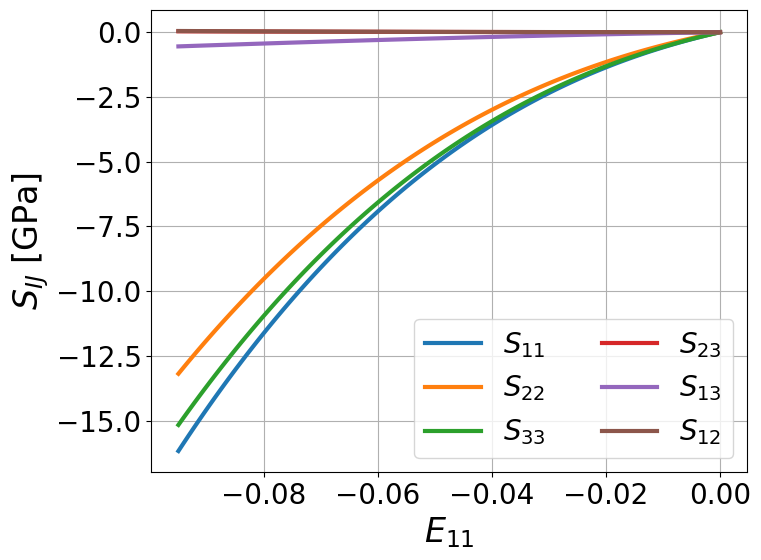

In [5]:
F_vec = []
det_F = []
E_voigt = []
voigt_notation = [11, 22, 33, 23, 13, 12]
multiplier = np.linspace(0.9, 1., num=100)
for mul in multiplier:
    F = mul * np.eye(3)
    J = np.linalg.det(F)
    E = 0.5 * (F.T @ F - np.eye(3))
    F_vec.append(mat2vec(F))
    det_F.append(J)
    E_voigt.append(mat2voigt(E))
F_vec = np.stack(F_vec)
det_F = np.array(det_F)
E_voigt = np.stack(E_voigt)
E_voigt[:, -3:] *= 2.
Temp = 300. * np.ones((E_voigt.shape[0], 1))

stress = compute_stress(E_voigt, Temp, C_ij, C_ijk, C_ijkl, beta_i, beta_ij, beta_prime_i)
E_voigt[:, -3:] /= 2.
strain_comp = 11
plot_SE(E_voigt, strain_comp, stress, voigt_notation)